In [2]:
import os
import json
import numpy as np
import laspy as lp
import pyvista as pv
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

def get_las_file_paths(root_dir):
    las_file_paths = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.las'):
                las_file_paths.append(os.path.join(root, file))
    return las_file_paths

def view_cloud_pv(points):
    xyz = points[:, :3]  # Primeras 3 columnas: X, Y, Z
    rgb = points[:, 3:6]  # Columnas 4-6: R, G, B
    
    # Normalizar RGB de 16-bit (LAS) a 8-bit (0-255)
    if np.issubdtype(rgb.dtype, np.integer) and rgb.max() > 255:
        rgb = (rgb // 256).astype(np.uint8)  # Conversión a 8-bit
    
    # Crear objeto PolyData con coordenadas
    cloud = pv.PolyData(xyz)
    
    # Añadir colores RGB como array asociado a los puntos
    cloud["RGB"] = rgb.astype(np.uint8)  # Asegurar tipo uint8
    
    # Configurar plotter
    plotter = pv.Plotter()
    plotter.add_mesh(
        cloud,
        scalars="RGB",  # Usar el array RGB
        rgb=True,       # Indicar que son canales RGB
        point_size=3,   # Tamaño de los puntos
        opacity=1       # Opacidad total
    )
    
    plotter.show()

def generate_dem(points, rasante, grid_spacing=None):
    # Extraer y procesar coordenadas
    x, y, z = points[:, 0], points[:, 1], points[:, 2] - rasante
    z = np.clip(z, -0.01, 4)

    # Calcular espaciado de la grilla
    if grid_spacing is None:
        dx = np.diff(x)
        dy = np.diff(y)
        point_spacing = np.mean(np.sqrt(dx**2 + dy**2))
        grid_spacing = point_spacing
    
    # Crear dimensiones de la grilla
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    cols = int(np.ceil((x_max - x_min) / grid_spacing))
    rows = int(np.ceil((y_max - y_min) / grid_spacing))

    # Binning para promedio de elevaciones
    grid_sum = np.zeros((rows, cols))
    grid_count = np.zeros((rows, cols))
    
    xi = ((x - x_min) / grid_spacing).astype(int)
    yi = ((y_max - y) / grid_spacing).astype(int)
    
    np.add.at(grid_sum, (yi, xi), z)
    np.add.at(grid_count, (yi, xi), 1)
    
    dem = np.divide(grid_sum, grid_count, where=grid_count != 0)
    dem[grid_count == 0] = np.nan

    return dem


def get_points(path):
    las = lp.read(path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    rgb = np.vstack((las.red, las.green, las.blue)).transpose()
    data_points = np.hstack((
        points,
        rgb,
        np.expand_dims(las.return_number, -1),
        np.expand_dims(las.number_of_returns, -1)
    ))

    #single = data_points[data_points[:, -1] == 1][:, :6]  #XYZRGB
    #first  = data_points[(data_points[:, -1] == 2) & (data_points[:, -2] == 1)]
    #second = data_points[(data_points[:, -1] == 2) & (data_points[:, -2] == 2)]
    return data_points #single, first, second

def get_roi(points, p=0.05):
    # Obtener límites originales
    x_min = np.min(points[:, 0])
    x_max = np.max(points[:, 0])
    y_min = np.min(points[:, 1])
    y_max = np.max(points[:, 1])
    
    # Calcular 5% del largo de cada eje
    x_offset = p * (x_max - x_min)
    y_offset = p * (y_max - y_min)
    
    # Ajustar límites hacia adentro
    new_x_min = x_min + x_offset
    new_x_max = x_max - x_offset
    new_y_min = y_min + y_offset
    new_y_max = y_max - y_offset
    
    return new_x_min, new_x_max, new_y_min, new_y_max

def bresenham_line(start=(10, 10), end=(10, 60)):
    # Unpack start and end points
    x1, y1 = np.array(start, dtype=np.int32).copy()
    x2, y2 = np.array(end, dtype=np.int32).copy()


    # Calculate differences
    dx = x2 - x1
    dy = y2 - y1

    # Determine if the line is steep (more vertical than horizontal)
    is_steep = abs(dy) > abs(dx)

    # Swap coordinates if the line is steep (for easier handling)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Ensure the line is always drawn left-to-right
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    # Recalculate differences after the possible swap
    dx = x2 - x1
    dy = y2 - y1

    # Error term initialized to half of dx
    error = dx // 2
    ystep = 1 if y1 < y2 else -1  # Determines whether to increment or decrement y

    # List to store the generated points
    points = []
    y = y1

    # Main loop for Bresenham's algorithm
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)  # Swap x and y if the line is steep
        points.append(coord)

        # Update error term
        error -= abs(dy)

        # If error is negative, adjust y and reset the error term
        if error < 0:
            y += ystep
            error += dx

    return points


In [5]:

df = pd.read_csv('data/vuelos/data_sqm.csv')

POZAS = {}

for index, row in df.iterrows():
    fecha = row['Fecha']
    poza = row['Poza'].replace('-','').lower()
    rasante = row['Rasante (m)']
    cota_salm = row['Cota Salm. (m)']
    cota_sal = row['Cota Sal (m)']
    sal = row['Sal (cm)']
    salmuera = row['Salmuera (cm)']

    if poza not in POZAS:
        POZAS[poza] = {}

    POZAS[poza][fecha] = {
        'Rasante (m)': rasante,
        'Cota Salmuera sqm (m)': cota_salm,
        'Cota Sal sqm (m)': cota_sal,
        'Sal sqm (cm)': sal,
        'Salmuera sqm (cm)': salmuera
    }


2300.455


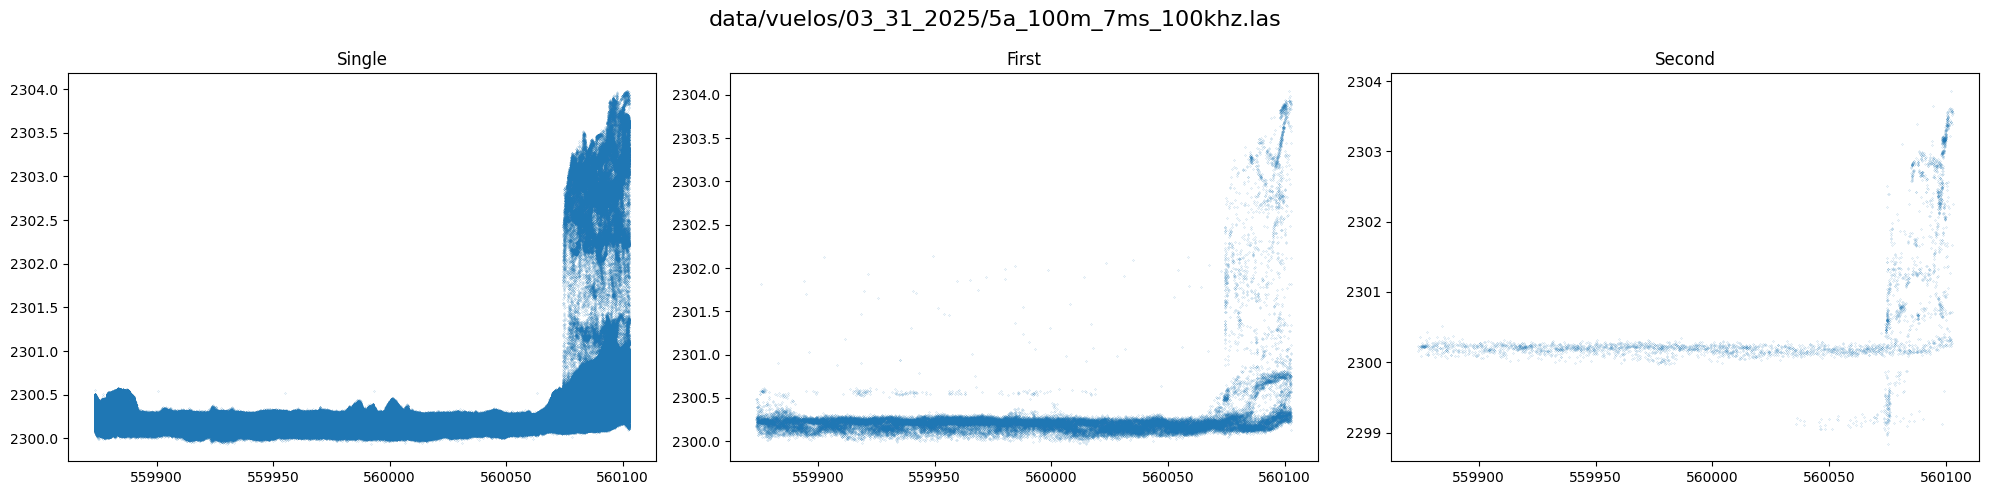

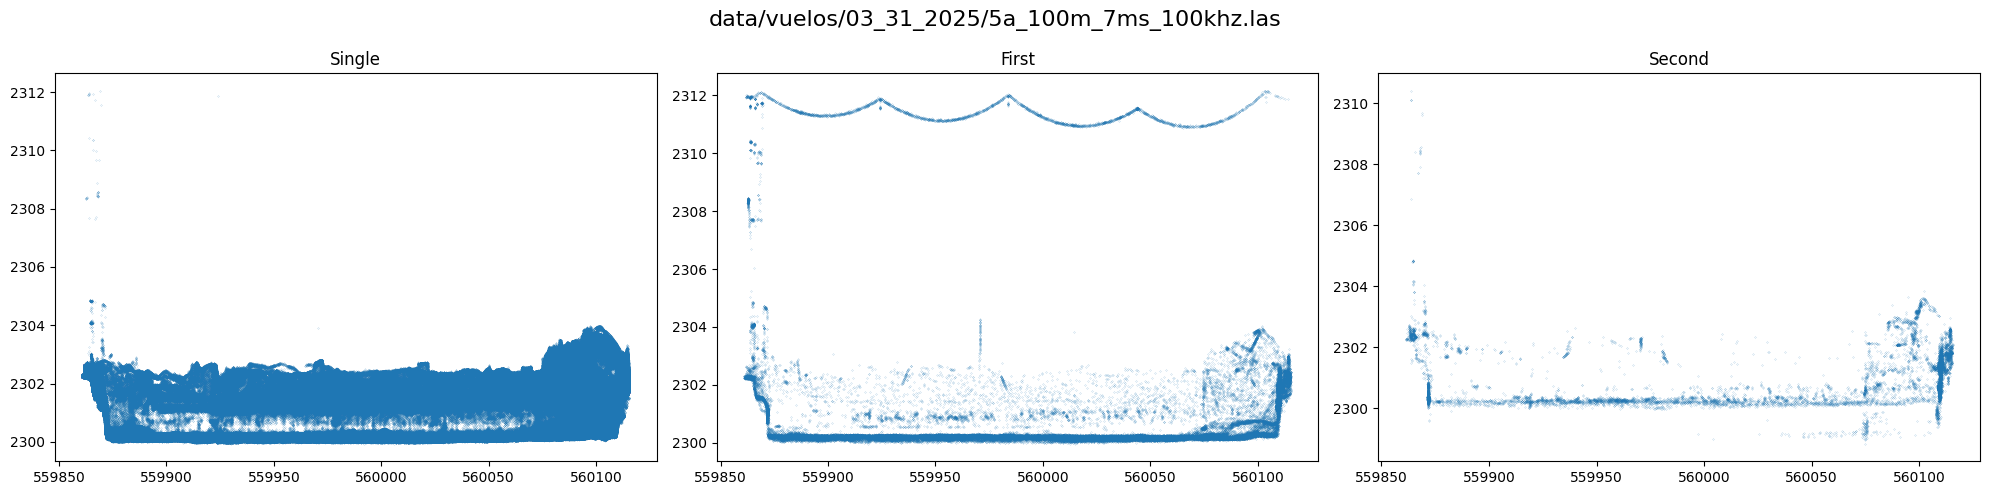

In [9]:
import matplotlib.pyplot as plt
root_directory = 'data/vuelos'
las_file_paths = sorted(get_las_file_paths(root_directory))

for path in las_file_paths:
   if '7ms' in path:
      _,_,date,filename = path.split('/')
      DATE = date.replace('_','/')
      date = date.replace('_','')
      POZA, H, V, F, = filename[:-4].split('_')
      SECTOR = None
      if len(POZA.split('-')) != 1:
         POZA, SECTOR = POZA.split('-')
      PDATA = POZAS.get(POZA).get(DATE)


      data_points = get_points(path)

      single = data_points[data_points[:, -1] == 1]
      first  = data_points[(data_points[:, -1] == 2) & (data_points[:, -2] == 1)]
      second = data_points[(data_points[:, -1] == 2) & (data_points[:, -2] == 2)]
         
      x_min, x_max, y_min, y_max = get_roi(single)
      mask_s = (single[:, 0] >= x_min) & (single[:, 0] <= x_max) & \
          (single[:, 1] >= y_min) & (single[:, 1] <= y_max)
         
      x_min, x_max, y_min, y_max = get_roi(first)
      mask_f = (first[:, 0] >= x_min) & (first[:, 0] <= x_max) & \
          (first[:, 1] >= y_min) & (first[:, 1] <= y_max) #& \
          #(first[:,2] < PDATA.get('Cota Salmuera sqm (m)'))
      print(PDATA.get('Cota Salmuera sqm (m)'))   
      x_min, x_max, y_min, y_max = get_roi(second)
      mask_s2 = (second[:, 0] >= x_min) & (second[:, 0] <= x_max) & \
          (second[:, 1] >= y_min) & (second[:, 1] <= y_max) #& \
          #(second[:,2] < PDATA.get('Cota Salmuera sqm (m)'))
         
      s = single[mask_s]
      f = first[mask_f]
      s2 = second[mask_s2]
      
      xs,ys,zs= s[:,0], s[:,1], s[:,2]   
      xf,yf,zf= f[:,0],f[:,1], f[:,2]   
      xs2,ys2,zs2= s2[:,0],s2[:,1], s2[:,2]   

      # ss2 = np.vstack((s[:,:3],s2[:,:3]))
      # sf = np.vstack((s[:,:3],f[:,:3]))
      # sfs2 = np.vstack((s[:,:3],f[:,:3], ss2[:,:3]))

      # dem_s = generate_dem(s, PDATA.get('Rasante (m)'))
      # dem_ss2 = generate_dem(ss2, PDATA.get('Rasante (m)'))
      # dem_sf = generate_dem(ss2, PDATA.get('Rasante (m)'))
      # dem = generate_dem(sfs2, PDATA.get('Rasante (m)'))

      # fig, axs = plt.subplots(1, 4, figsize=(15, 5))
      # axs[0].imshow(dem_s)
      # axs[0].set_title('Single')
      # axs[1].imshow(dem_sf)
      # axs[1].set_title('Single + first')
      # axs[2].imshow(dem_ss2)
      # axs[2].set_title('Single + Second')
      # axs[3].imshow(dem)
      # axs[3].set_title('Single + First + Second')
      # fig.suptitle('DEMs', fontsize=16)
      # plt.tight_layout()
      # plt.show()
         
      fig, axs = plt.subplots(1, 3, figsize=(20, 5))
      axs[0].scatter(xs, zs, s=0.01)
      axs[0].set_title('Single')
      axs[1].scatter(xf, zf, s=0.01)
      axs[1].set_title('First')
      axs[2].scatter(xs2, zs2, s=0.01)
      axs[2].set_title('Second')
      fig.suptitle(path, fontsize=16)
      plt.tight_layout()
      plt.show()


      s = single
      f = first
      s2 = second
      
      xs,ys,zs= s[:,0], s[:,1], s[:,2]   
      xf,yf,zf= f[:,0],f[:,1], f[:,2]   
      xs2,ys2,zs2= s2[:,0],s2[:,1], s2[:,2]   

      fig, axs = plt.subplots(1, 3, figsize=(20, 5))
      axs[0].scatter(xs, zs, s=0.01)
      axs[0].set_title('Single')
      axs[1].scatter(xf, zf, s=0.01)
      axs[1].set_title('First')
      axs[2].scatter(xs2, zs2, s=0.01)
      axs[2].set_title('Second')
      fig.suptitle(path, fontsize=16)
      plt.tight_layout()
      plt.show()
      break



data/vuelos/04_14_2025/3a-v1_100m_10ms_100khz.las
Cantidad de elementos en la penúltima columna: 12937125
Cantidad de elementos en la última columna: 12937125
(9713436, 6)


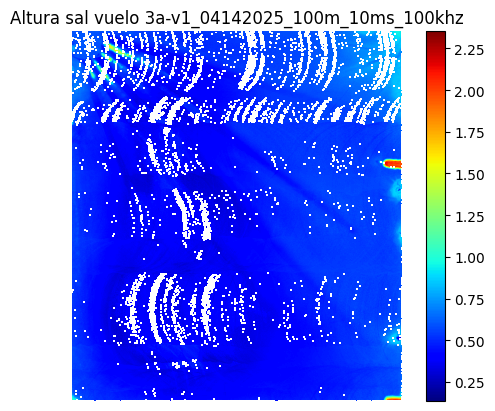

data/vuelos/04_14_2025/3a-v2_100m_10ms_100khz.las
Cantidad de elementos en la penúltima columna: 20674996
Cantidad de elementos en la última columna: 20674996
(15542814, 6)


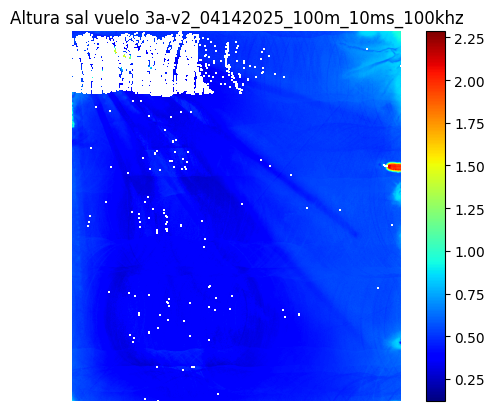

In [ ]:
import gc 

root_directory = 'data/vuelos'
las_file_paths = sorted(get_las_file_paths(root_directory))

for path in las_file_paths:
    ## Get info
    _,_,date,filename = path.split('/')
    DATE = date.replace('_','/')
    date = date.replace('_','')
    POZA, H, V, F, = filename[:-4].split('_')
    SECTOR = None
    if len(POZA.split('-')) != 1:
        POZA, SECTOR = POZA.split('-')
    PDATA = POZAS.get(POZA).get(DATE)

    ## Analysis
    points = get_points(path)
    x_min, x_max, y_min, y_max = get_roi(points)
    mask = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & \
       (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
    roi_points = points[mask]

    del points
    gc.collect()    

    HSAL = np.mean(roi_points[:,2] - PDATA.get('Rasante (m)'))*100
    AREA = (x_max - x_min) * (y_max - y_min) 

    ## Create DEM
    dem = generate_dem(roi_points, PDATA.get('Rasante (m)'))
    
    del roi_points
    gc.collect()
    
    ## Save DEM and data
    dem_pil = Image.fromarray(dem)
    save_path = f'{root_directory}/results/{POZA}_{date}_{H}_{V}_{F}' if SECTOR is None else f'{root_directory}/results/{POZA}-{SECTOR}_{date}_{H}_{V}_{F}'
    dem_pil.save(f'{save_path}.tiff')

    del dem_pil
    gc.collect()
    
    h, w = dem.shape
    d1 = bresenham_line(start=(0, 0), end=(h-1,w-1))
    d2 = bresenham_line(start=(h-1, 0), end=(0,w-1))
    dem_d1 = np.array([(idx, dem[x][y]) for idx, (x, y) in enumerate(d1) ])
    dem_d2 = np.array([(idx, dem[x][y]) for idx, (x, y) in enumerate(d2) ])
       
    result = {
        'altura sal (cm) (lidar)': HSAL,
        'Area poza medida': AREA,
        'data_sqm': PDATA,
        'diagonal1':{
            'unit':     '[m]',
            'mean':     float(np.mean([i for i in dem_d1[:,1] if not np.isnan(i)])),
            'x_axis':   dem_d1[:,0].tolist(),
            'y_axis':   dem_d1[:,1].tolist()

        },
        'diagonal2':{
            'unit':     '[m]',
            'mean':     float(np.mean([i for i in dem_d2[:,1] if not np.isnan(i)])),
            'x_axis':   dem_d2[:,0].tolist(),
            'y_axis':   dem_d2[:,1].tolist()
        }
    }

    with open(f'{save_path}.json', 'w') as f:
        json.dump(result, f, indent=4)

    ## Save DEM png OPTINAL
    plt.imshow(dem, cmap='jet')
    plt.colorbar()
    plt.title(f'Altura sal vuelo {save_path.split("/")[-1]}')  
    plt.axis('off')
    plt.savefig(f'{save_path}.png')
    plt.show()

    del dem
    gc.collect()